# P7 : implémentation d'un modèle de scoring
---
**Description du projet :** 

L’entreprise "Prêt à dépenser" souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

---

## 0. Librairies 

In [1]:
#reload all modules before executing code
%load_ext autoreload
%autoreload 2
#e

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re
import imblearn
import sklearn.metrics
import lightgbm as lgb

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline # pipleline imblearn et non scikit learn
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
#import du fichier de fonctions
import sol_functions as sf

---

## Description des données

Les données et leurs descriptions sont disponibles sur le site de la compétition Kaggle : https://www.kaggle.com/competitions/home-credit-default-risk/overview

On a 7 sources de données : 
- application_train/application_test : données principales contenant les informations sur chaque demande de prêt. Chaque prêt a sa propre ligne et est identifié par la variable `SK_ID_CURR`. La target est identifiée par la variable `TARGET` **indiquant 0 pour un prêt remboursé et 1 pour un prêt non remboursé.**

- bureau : données concernant les crédits précédents du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.

- bureau_balance : données mensuelles sur les crédits précédents dans le bureau. Chaque ligne correspond à un mois de crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

- previous_application : demandes précédentes de prêts des clients qui ont des prêts dans les données de demande. Chaque prêt actuel dans les données de la demande peut avoir plusieurs prêts précédents. Chaque demande antérieure a une ligne et est identifiée par la caractéristique `SK_ID_PREV`.

- POS_CASH_BALANCE : données mensuelles sur les précédents prêts au point de vente ou au comptant que les clients. Chaque ligne représente un mois d'un précédent prêt au point de vente ou au comptant, et un seul prêt précédent peut avoir plusieurs lignes.

- credit_card_balance : données mensuelles sur les cartes de crédit que les clients ont eues. Chaque ligne représente un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.

- installments_payment : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

Ce diagramme montre comment toutes les données sont liées :

![alt text](home_credit.png "")

De plus, on nous fournit les définitions de toutes les colonnes (dans HomeCredit_columns_description.csv) et un exemple du fichier de soumission attendu.

## Aperçu des données

Tout d'abord, nous pouvons énumérer tous les fichiers de données disponibles.

In [4]:
# List files available
display(os.listdir("data/"))

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

Il y a un total de 10 fichiers : 1 fichier principal pour l'entraînement (avec la target) 1 fichier principal pour le test (sans la target), 1 fichier de soumission d'exemple, et 7 autres fichiers contenant des informations supplémentaires sur chaque prêt.

In [5]:
# Training data
app_train = pd.read_csv('data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Le fichier de Train contient 307511 observations (chacune étant un prêt distinct) et 122 caractéristiques (variables), y compris la TARGET (l'étiquette que nous voulons prédire).

In [6]:
# Testing data features
app_test = pd.read_csv('data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Le fichier de Test est considérablement plus petit et ne comporte pas de colonne TARGET.

La signification des varibles de tous les fichiers est décrite dans le fichier HomeCredit_columns_description.csv.

In [7]:
print("Description des variables des fichiers:")
pd.set_option("max_colwidth", None)
description = pd.read_csv('data/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description.head()

Description des variables des fichiers:


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


## **Analyse exploratoire**

### Distribution de la target :

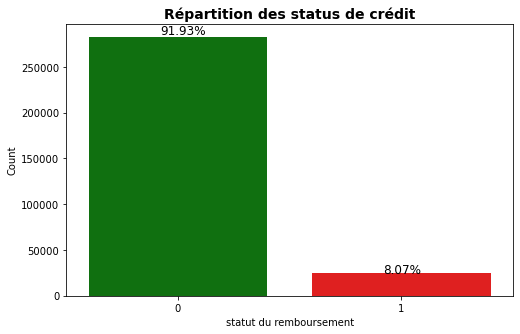

In [8]:
plt.figure(figsize = (8,5))
ax = sns.countplot("TARGET", data= app_train, palette=['g','r'])

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(app_train.TARGET))
    x = p.get_x() + p.get_width() / 2.5
    y = p.get_y() + p.get_height() * 1.01
    ax.annotate(percentage, (x, y), fontsize=12)

plt.ylabel("Count")
plt.xlabel('statut du remboursement')
plt.title("Répartition des status de crédit",fontsize=14, fontweight='bold')
plt.show()

Prêt de 92 % des prêts sont remboursés, et 8% ne le sont pas.

D'après ces informations, nous constatons qu'il s'agit d'un problème de classe déséquilibrée. Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes en fonction de leur représentation dans les données afin de refléter ce déséquilibre.

### Correlation avec la target

In [9]:
#Display correlations
print('5 top correlations positives avec TARGET:\n\n', app_train.corr()['TARGET'].sort_values().tail(5))
print("--------------------------")
print('5 top correlations négatives avec TARGET:\n\n', app_train.corr()['TARGET'].sort_values().head(5))

5 top correlations positives avec TARGET:

 DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
5 top correlations négatives avec TARGET:

 EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044932
FLOORSMAX_AVG   -0.044003
Name: TARGET, dtype: float64


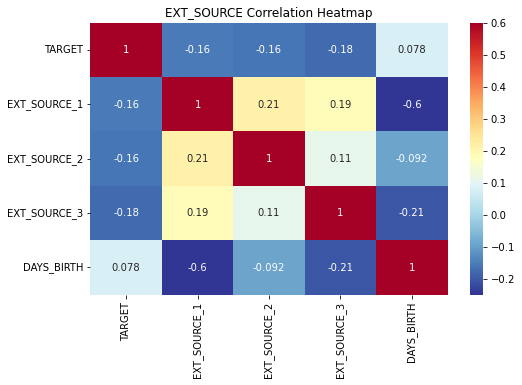

In [10]:
#Heatmap of correlations
plt.figure(figsize = (8,5))
sns.heatmap(app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
plt.show()

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de la EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

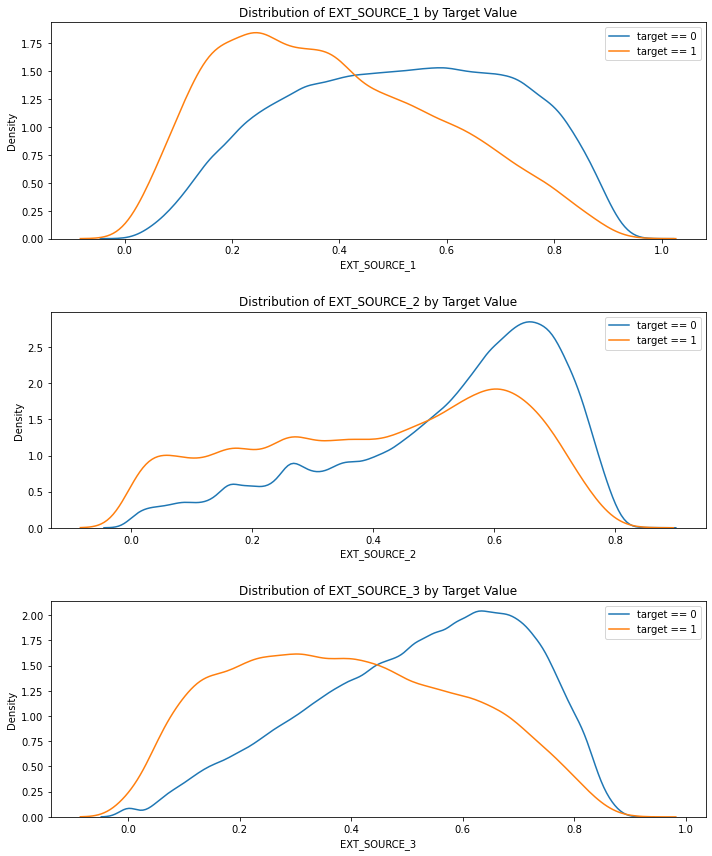

In [11]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    plt.legend()
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte. En fait, elles sont toutes considérées comme très faibles, mais ces variables seront tout de même utiles à un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt à temps

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

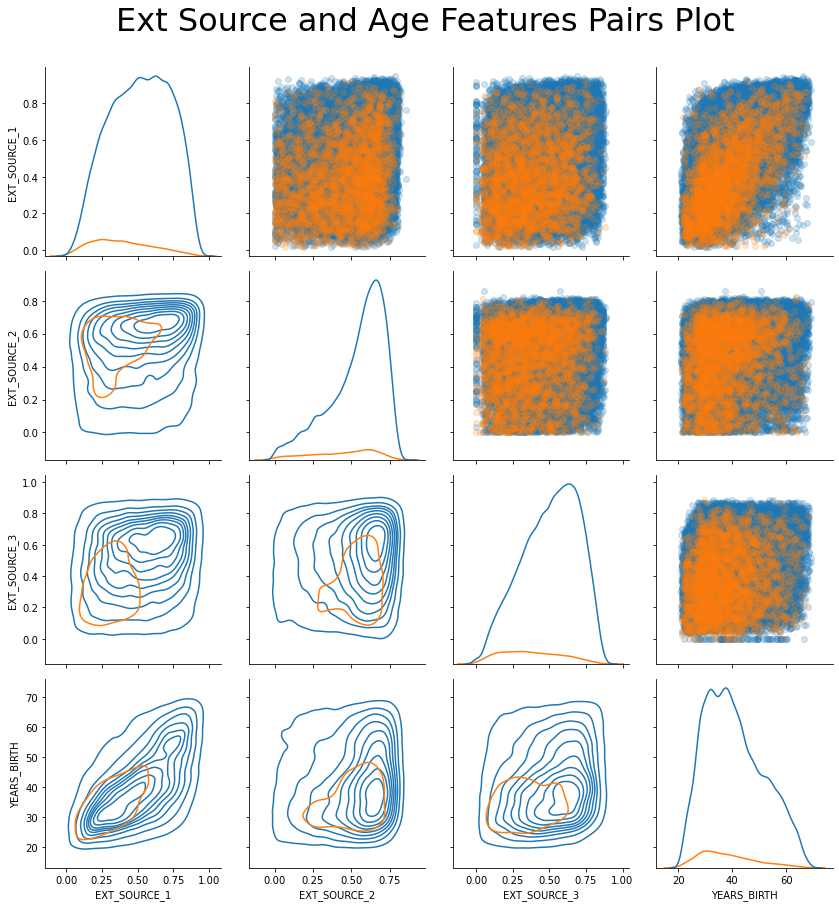

In [12]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Age information into a separate dataframe
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)

## Feature engineering

Cette partie est entierement inspirée du notebook kaggle suivant https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/

In [13]:
with sf.timer("Process application_train and application_test"):
    df = sf.application_train_test()
    print("Application df shape:", df.shape)

print("\n--------------------------------\n")
    
with sf.timer("Process bureau and bureau_balance"):
    bureau = sf.bureau_and_balance()
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

print("\n--------------------------------\n")

with sf.timer("Process previous_applications"):
    prev = sf.previous_applications()
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

print("\n--------------------------------\n")    
    
with sf.timer("Process POS-CASH balance"):
    pos = sf.pos_cash()
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
print("\n--------------------------------\n")

with sf.timer("Process installments payments"):
    ins = sf.installments_payments()
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
print("\n--------------------------------\n")

with sf.timer("Process credit card balance"):
    cc = sf.credit_card_balance()
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Train samples: 307511, test samples: 48744
Application df shape: (356251, 248)
Process application_train and application_test - done in 3s

--------------------------------

Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 14s

--------------------------------

Previous applications df shape: (338857, 249)
Process previous_applications - done in 14s

--------------------------------

Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s

--------------------------------

Installments payments df shape: (339587, 26)
Process installments payments - done in 20s

--------------------------------

Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s


In [14]:
df.shape

(356251, 798)

In [15]:
#rename des colonnes pour le lgbm
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [16]:
# training/validation and test data

ignore_features = ['SK_ID_CURR', 'INDEX']
relevant_features = [col for col in df.columns if col not in ignore_features]

train_df = df[df['TARGET'].notnull()][relevant_features]
test_df = df[df['TARGET'].isnull()]

In [17]:
print("train_df shape :", train_df.shape)
print("train_df shape :", test_df.shape)

train_df shape : (307507, 797)
train_df shape : (48744, 798)


In [18]:
# On sauvegarde le dataframe test_df après feature engeniering
# Il ne nous servira pas pour la modélisation mais sera utilisé pour 
# les prédiction sur le dashbord qui sera réalisé par la suite
test_df.to_csv('test_df.csv')

## Modélisation

### Sampling des données

Le jeu de données étant relativement important, nous allons utiliser un sampling des données.

In [19]:
# Sampling
data = train_df.sample(100000, random_state=42)

In [20]:
Y = data["TARGET"]
X = data.drop("TARGET", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.8, random_state=42, 
                                                    stratify=Y)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 80000 lignes,
Test: 20000 lignes.



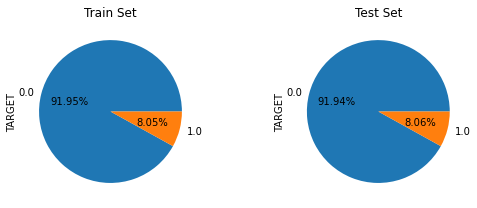

In [21]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

### Preprocessing

In [22]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)

In [23]:
# Fit on the training data
X_train[X_train==np.inf] = np.nan
imputer.fit(X_train)

SimpleImputer(strategy='median', verbose=0)

In [24]:
# Transform training data

X_test[X_test==np.inf] = np.nan

X_train_preproc = imputer.transform(X_train)
X_test_preproc = imputer.transform(X_test)

In [25]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

In [26]:
# Repeat with the scaler
scaler.fit(X_train_preproc)
X_train_preproc = scaler.transform(X_train_preproc)
X_test_preproc = scaler.transform(X_test_preproc)

In [27]:
xtrain = pd.DataFrame(scaler.transform(X_train_preproc), 
                      index=X_train.index, 
                      columns=X_train.columns)

xtest = pd.DataFrame(scaler.transform(X_test_preproc), 
                     index=X_test.index, 
                     columns=X_test.columns)

### Test de modèles

In [28]:
results = pd.DataFrame(columns=["Algorithm", "Balancing_method",
                                "AUC", "AUC_test", "Time"])

In [29]:
#Undersampling
rus = RandomUnderSampler(random_state=6)
xtrain_us, ytrain_us = rus.fit_resample(xtrain, y_train)

#Oversampling
smote = SMOTE(random_state=6)
xtrain_os, ytrain_os = smote.fit_resample(xtrain, y_train)

#### Baseline : Dummyclassifier

In [30]:
dc1 = DummyClassifier(strategy="most_frequent")

In [31]:
#undersampling
row = sf.evaluate_model(dc1, xtrain_us, ytrain_us, xtest, y_test, \
                        "Baseline", "Undersampling")

In [32]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.001001


In [33]:
#oversampling
row = sf.evaluate_model(dc1, xtrain_os, ytrain_os, xtest, y_test, \
                        "Baseline", "Oversampling")

In [34]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.5,0.5,0.001001
1,Baseline,Oversampling,0.5,0.5,0.004003


In [35]:
#class_weight='balanced' : simulation en utilisant la stratégie "stratified"
dc2 = DummyClassifier(strategy="stratified")
row = sf.evaluate_model(dc2, xtrain, y_train, xtest, y_test, \
                        "Baseline", "Balanced")

In [36]:
row = sf.evaluate_model(dc2, xtrain, y_train, xtest, y_test, \
                        "Baseline", "Balanced")

In [37]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010


#### Régression logistique

In [40]:
lr = LogisticRegression()
lr_balanced = LogisticRegression(class_weight="balanced")

In [41]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr = GridSearchCV(
    lr,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lr_balanced = GridSearchCV(
    lr_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [43]:
#undersampling
row = sf.evaluate_model(gs_lr, xtrain_us, ytrain_us, xtest, y_test, \
                        "LogisticRegression", "Undersampling")

In [44]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923


In [47]:
#oversampling, imbalanced learn et non scikit learn
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', LogisticRegression())
    ])

params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

row = sf.evaluate_model(gs_lr_os, xtrain, y_train, xtest, y_test, \
                        "LogisticRegression", "Oversampling")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408


In [48]:
#class_weight='balanced'
row = sf.evaluate_model(gs_lr_balanced, xtrain, y_train, xtest, y_test, \
                        "LogisticRegression", "Balanced")

In [49]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408
5,LogisticRegression,Balanced,0.745,0.763,119.814179


#### RamdomForestClassifier

In [51]:
rf = RandomForestClassifier(random_state = 0)

rf_balanced = RandomForestClassifier(random_state = 0, 
                                     class_weight="balanced")

In [52]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10]
}

gs_rf = GridSearchCV(
    rf,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_rf_balanced = GridSearchCV(
    rf_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [53]:
#undersampling
row = sf.evaluate_model(gs_rf, xtrain_us, ytrain_us, xtest, y_test, \
                        "RandomForest", "Undersampling")

In [54]:
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408
5,LogisticRegression,Balanced,0.745,0.763,119.814179
6,RandomForest,Undersampling,0.734,0.751,18.203943


In [55]:
#oversampling
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', RandomForestClassifier(random_state = 42))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [5, 10]
}

gs_rf_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

row = sf.evaluate_model(gs_rf_os, xtrain, y_train, xtest, y_test, \
                        "RandomForest", "Oversampling")
                        
results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408
5,LogisticRegression,Balanced,0.745,0.763,119.814179
6,RandomForest,Undersampling,0.734,0.751,18.203943
7,RandomForest,Oversampling,0.669,0.681,451.651501


In [57]:
#class_weight='balanced'
row = sf.evaluate_model(gs_rf_balanced, xtrain, y_train, xtest, y_test, \
                        "RandomForest", "Balanced")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408
5,LogisticRegression,Balanced,0.745,0.763,119.814179
6,RandomForest,Undersampling,0.734,0.751,18.203943
7,RandomForest,Oversampling,0.669,0.681,451.651501
8,RandomForest,Balanced,0.724,0.734,93.023867


#### Light Gradient Boosting Machine

In [58]:
lgbm = lgb.LGBMClassifier(random_state = 0, objective = 'binary')

lgbm_balanced = lgb.LGBMClassifier(random_state = 0,
                                   objective = 'binary',
                                   class_weight = 'balanced')

In [59]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}

gs_lgbm = GridSearchCV(
    lgbm,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

gs_lgbm_balanced = GridSearchCV(
    lgbm_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

In [60]:
#undersampling
row = sf.evaluate_model(gs_lgbm, xtrain_us, ytrain_us, xtest, y_test, \
                        "LGBM", "Undersampling")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408
5,LogisticRegression,Balanced,0.745,0.763,119.814179
6,RandomForest,Undersampling,0.734,0.751,18.203943
7,RandomForest,Oversampling,0.669,0.681,451.651501
8,RandomForest,Balanced,0.724,0.734,93.023867
9,LGBM,Undersampling,0.761,0.776,36.500362


In [62]:
#oversampling
model = Pipeline([
        ('sampling', SMOTE()),
        ('clf', lgb.LGBMClassifier(random_state = 42, objective = 'binary'))
    ])

params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.05]
}

gs_lgbm_os = GridSearchCV(
    model,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
    n_jobs=-1
)

row = sf.evaluate_model(gs_lgbm_os, xtrain, y_train, xtest, y_test, \
                        "LGBM", "Oversampling")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408
5,LogisticRegression,Balanced,0.745,0.763,119.814179
6,RandomForest,Undersampling,0.734,0.751,18.203943
7,RandomForest,Oversampling,0.669,0.681,451.651501
8,RandomForest,Balanced,0.724,0.734,93.023867
9,LGBM,Undersampling,0.761,0.776,36.500362


In [63]:
#class_weight='balanced'
row = sf.evaluate_model(gs_lgbm_balanced, xtrain, y_train, xtest, y_test, \
                        "LGBM", "Balanced")

results.loc[len(results)] = row
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Undersampling,0.500,0.500,0.001001
1,Baseline,Oversampling,0.500,0.500,0.004003
2,Baseline,Balanced,0.499,0.506,0.002010
3,LogisticRegression,Undersampling,0.741,0.760,30.404923
4,LogisticRegression,Oversampling,0.732,0.754,500.315408
5,LogisticRegression,Balanced,0.745,0.763,119.814179
6,RandomForest,Undersampling,0.734,0.751,18.203943
7,RandomForest,Oversampling,0.669,0.681,451.651501
8,RandomForest,Balanced,0.724,0.734,93.023867
9,LGBM,Undersampling,0.761,0.776,36.500362


#### Conclusion choix du modèle


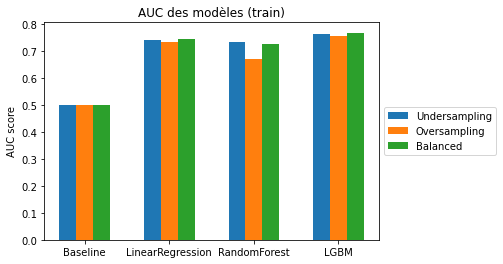

In [64]:
sf.plotComparaisonResults(results, 'AUC')

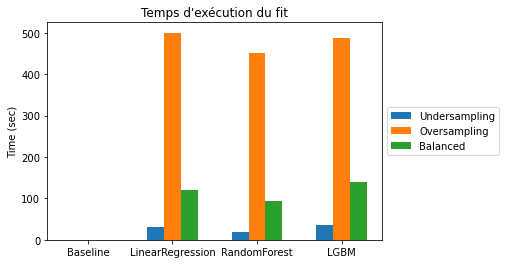

In [65]:
sf.plotComparaisonResults(results, 'Time')

L'algorithme Light Gradient Boosting Machine associé à la stratégie de rééquilibrage consistant à indiquer "balanced" comme valeur pour "weight_class" donne les meilleurs résultats sur notre jeu de données.

In [87]:
gs_lgbm_balanced.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced',
                                      objective='binary', random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='roc_auc')

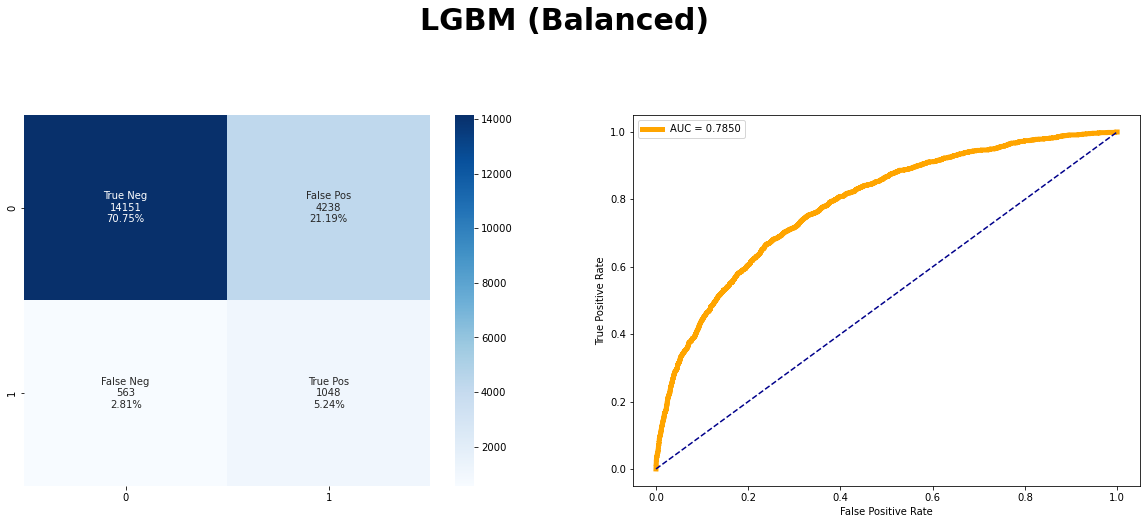

In [88]:

y_proba = gs_lgbm_balanced.predict_proba(X_test)
roc_auc = round(roc_auc_score(y_test, y_proba[:,1]),3)
sf.cf_matrix_roc_auc(gs_lgbm_balanced, y_test, gs_lgbm_balanced.predict(X_test), gs_lgbm_balanced.predict_proba(X_test)[:,1], roc_auc, "LGBM (Balanced)") 

### Feature importances

In [89]:
import shap

In [92]:
gs_lgbm_balanced.best_params_

{'learning_rate': 0.05, 'n_estimators': 200}

In [93]:
#best model
lgbm_balanced = lgb.LGBMClassifier(random_state = 0,
                                   objective = 'binary',
                                   class_weight = 'balanced',
                                   learning_rate=0.05,
                                   n_estimators= 200)

In [94]:
lgbm_balanced.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=200,
               objective='binary', random_state=0)

In [95]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm_balanced)
shap_values = explainer.shap_values(X_importance)

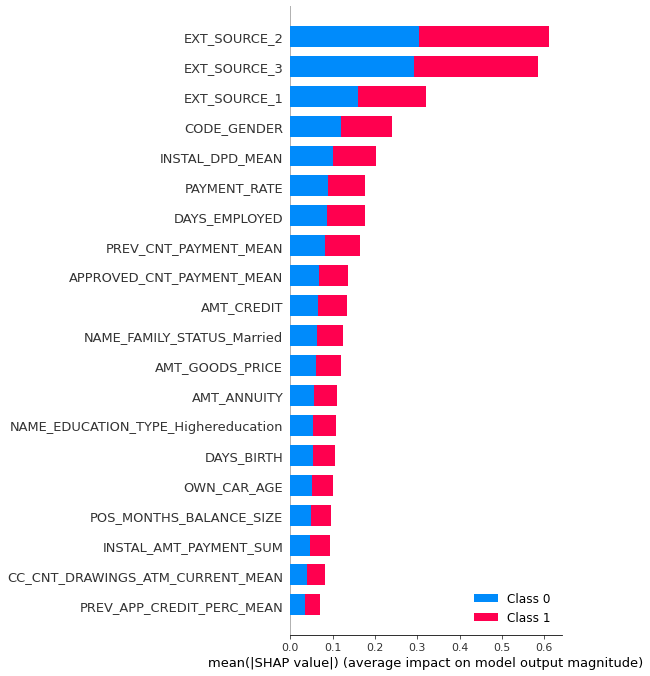

In [96]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

100%|===================| 79891/80000 [09:20<00:00]        

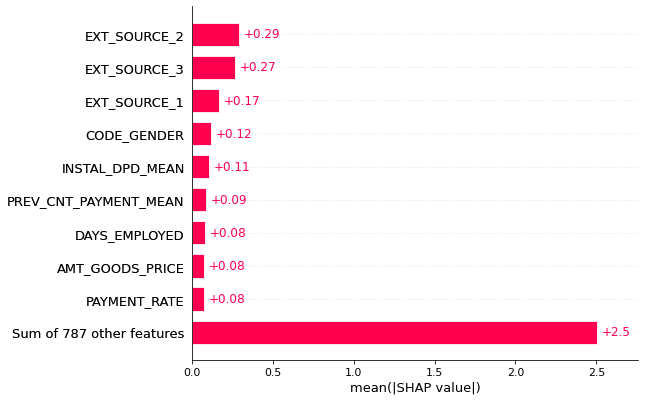

In [98]:
# compute SHAP values

explainer = shap.Explainer(lgbm_balanced, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values)

In [99]:
#Sauvegarde du modèle
import pickle
pickle.dump(lgbm_balanced, open("./LGBMClassifier.pkl", "wb"))

In [103]:
#Sauvegarde des fichiers au format parquet

application_train = pd.read_csv("data/application_train.csv")
application_test = pd.read_csv("data/application_test.csv")

application_train.to_parquet("data/application_train.parquet")
application_test.to_parquet("data/application_test.parquet")
test_df.to_parquet("data/test_df.parquet") 